In [33]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pandas as pd
%matplotlib inline


In [34]:
file_path = '../Data/FinalData.csv'
df = pd.read_csv(file_path)

features = ['co', 'no2', 'o3', 'pm10', 'pm25', 'so2', 'Temp', 'Rain', 'Cloud', 'Pressure', 'Wind', 'Gust']
data = df[features].values

scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# Chuẩn bị dữ liệu cho LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [36]:
# Định nghĩa mô hình LSTM
class AirQualityLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(AirQualityLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [57]:
# Tham số mô hình
input_size = 12
hidden_size = 50
num_layers = 2
output_size = 12
seq_length = 14
batch_size = 64
num_epochs = 150
learning_rate = 0.0005

In [58]:
# Tạo sequences
X, y = create_sequences(data_normalized, seq_length)

In [59]:
# Chia dữ liệu thành tập train và test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [60]:
# Chuyển sang tensor
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [61]:
# Tạo DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [62]:
# Khởi tạo mô hình, loss function và optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AirQualityLSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [63]:
# Huấn luyện mô hình
model.train()
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')


Epoch [10/150], Loss: 0.012017
Epoch [20/150], Loss: 0.009333
Epoch [30/150], Loss: 0.007580
Epoch [40/150], Loss: 0.005806
Epoch [50/150], Loss: 0.007180
Epoch [60/150], Loss: 0.006961
Epoch [70/150], Loss: 0.005911
Epoch [80/150], Loss: 0.006060
Epoch [90/150], Loss: 0.005911
Epoch [100/150], Loss: 0.006788
Epoch [110/150], Loss: 0.007068
Epoch [120/150], Loss: 0.005735
Epoch [130/150], Loss: 0.009913
Epoch [140/150], Loss: 0.005386
Epoch [150/150], Loss: 0.007550


In [64]:
# Dự đoán trên tập test
model.eval()
with torch.no_grad():
    X_test = X_test.to(device)
    predictions = model(X_test).cpu().numpy()
    y_test = y_test.numpy()

In [65]:
# Đưa dữ liệu về thang ban đầu
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

In [56]:
# Tính R² Score cho từng chỉ số
r2_scores = {}
feature_names = ['co', 'no2', 'o3', 'pm10', 'pm25', 'so2', 'Temp', 'Rain', 'Cloud', 'Pressure', 'Wind', 'Gust']
for i, feature in enumerate(feature_names):
    r2 = r2_score(y_test[:, i], predictions[:, i])
    r2_scores[feature] = r2
    print(f'R² Score for {feature}: {r2:.4f}')

R² Score for co: -0.0323
R² Score for no2: 0.7914
R² Score for o3: 0.3639
R² Score for pm10: 0.4485
R² Score for pm25: 0.7861
R² Score for so2: 0.8812
R² Score for Temp: 0.9047
R² Score for Rain: 0.2766
R² Score for Cloud: 0.5003
R² Score for Pressure: 0.9108
R² Score for Wind: 0.3987
R² Score for Gust: 0.3760


R² Score for co: -0.0148
R² Score for no2: 0.7873
R² Score for o3: 0.4123
R² Score for pm10: 0.4408
R² Score for pm25: 0.7994
R² Score for so2: 0.8565
R² Score for Temp: 0.9062
R² Score for Rain: 0.2766
R² Score for Cloud: 0.5058
R² Score for Pressure: 0.9129
R² Score for Wind: 0.3972
R² Score for Gust: 0.3828

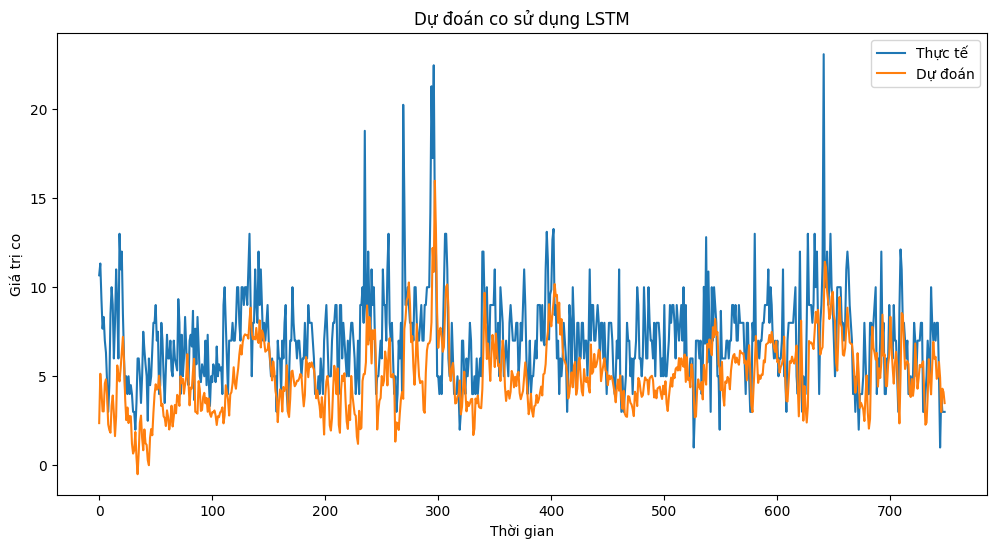

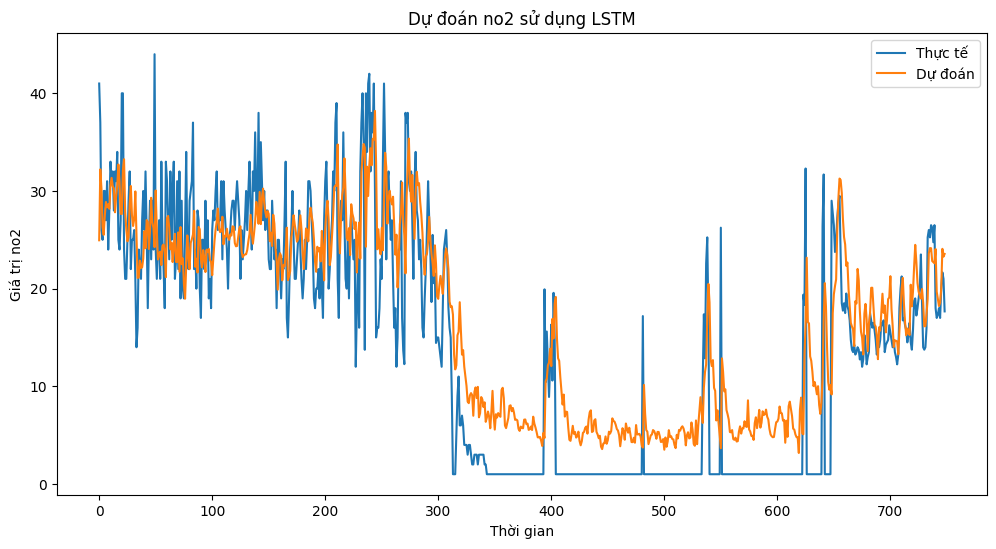

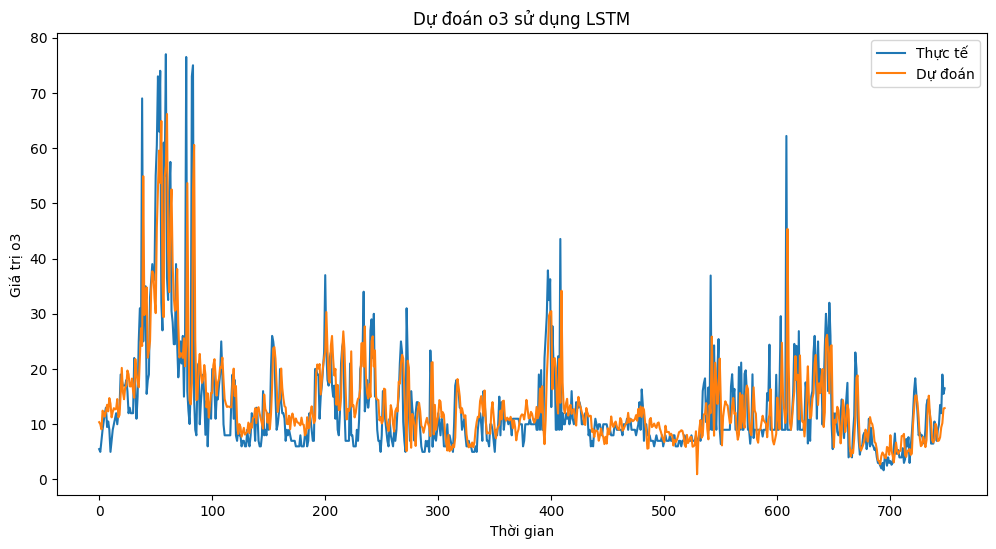

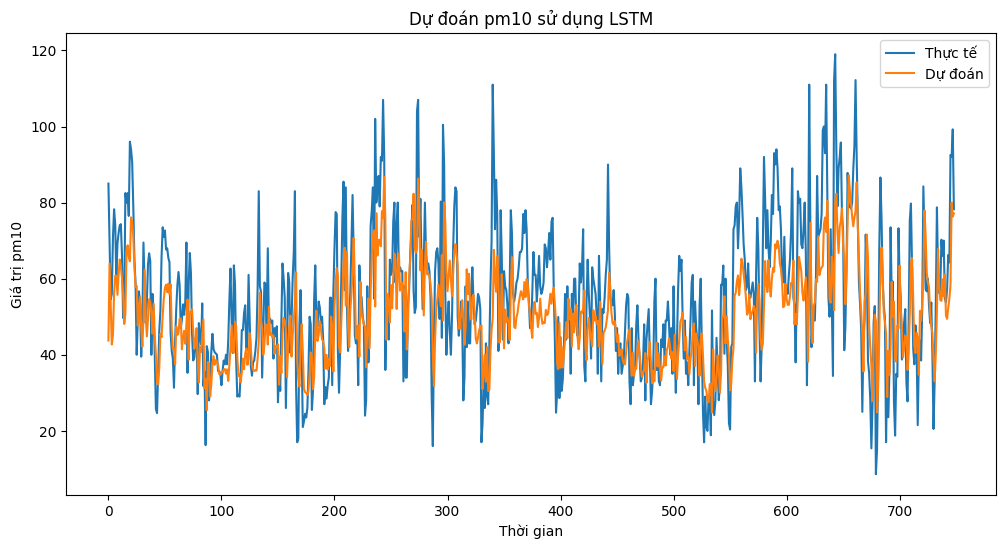

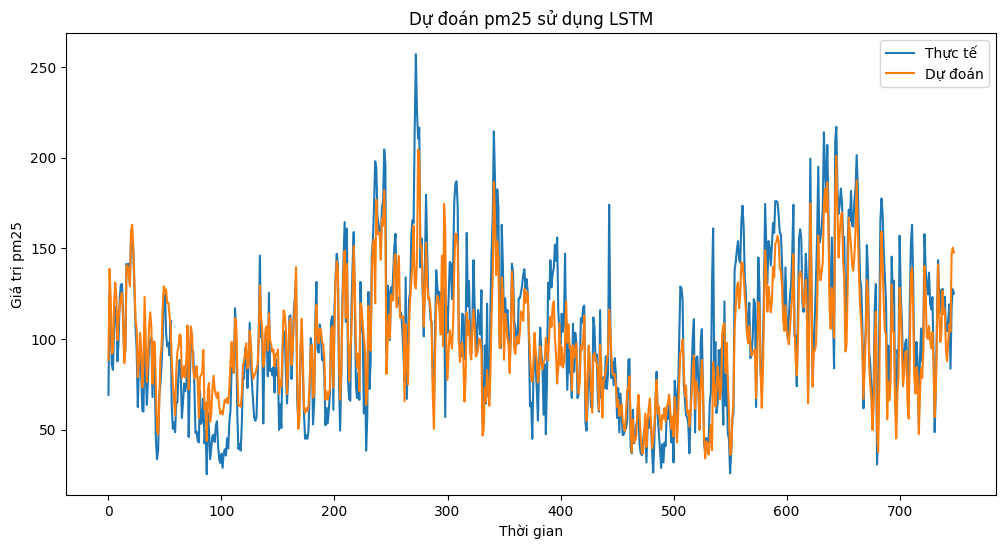

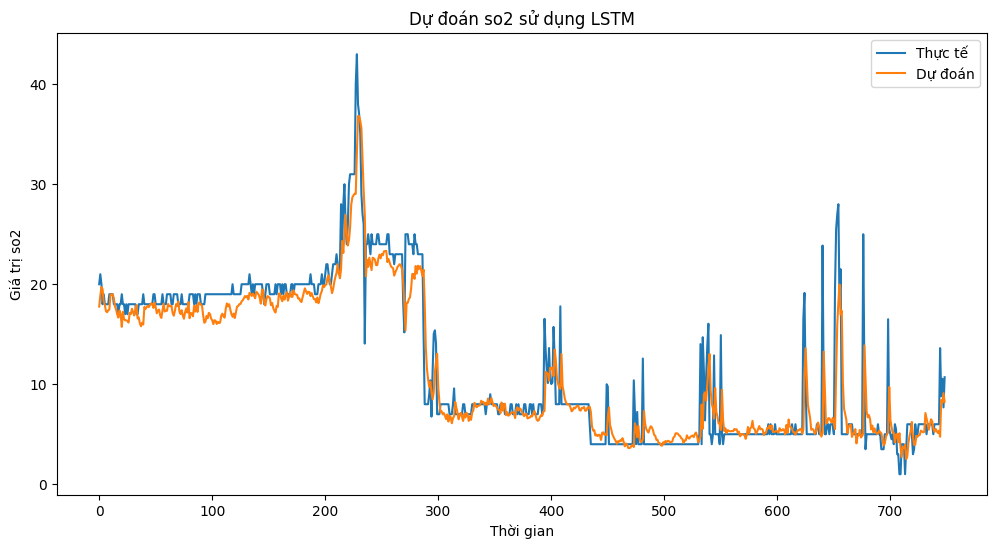

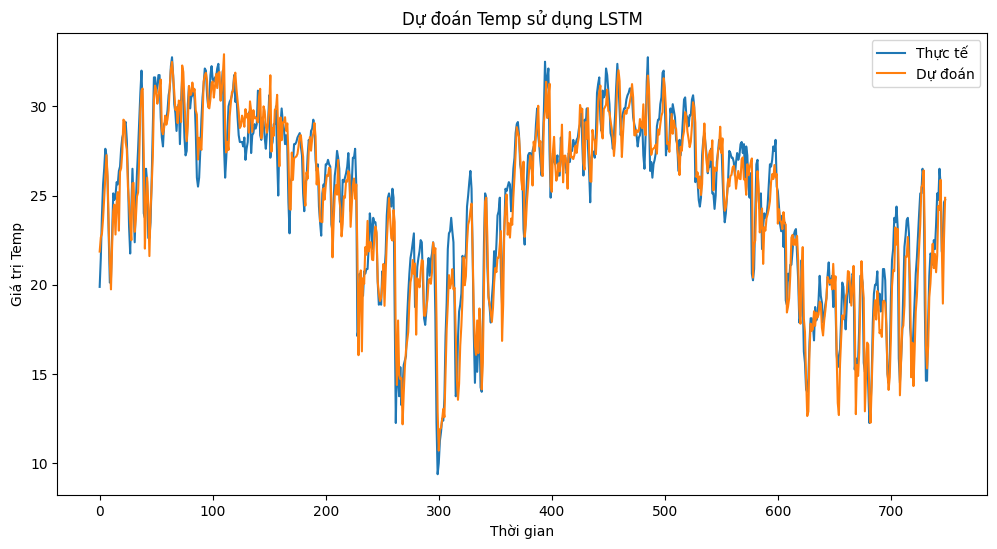

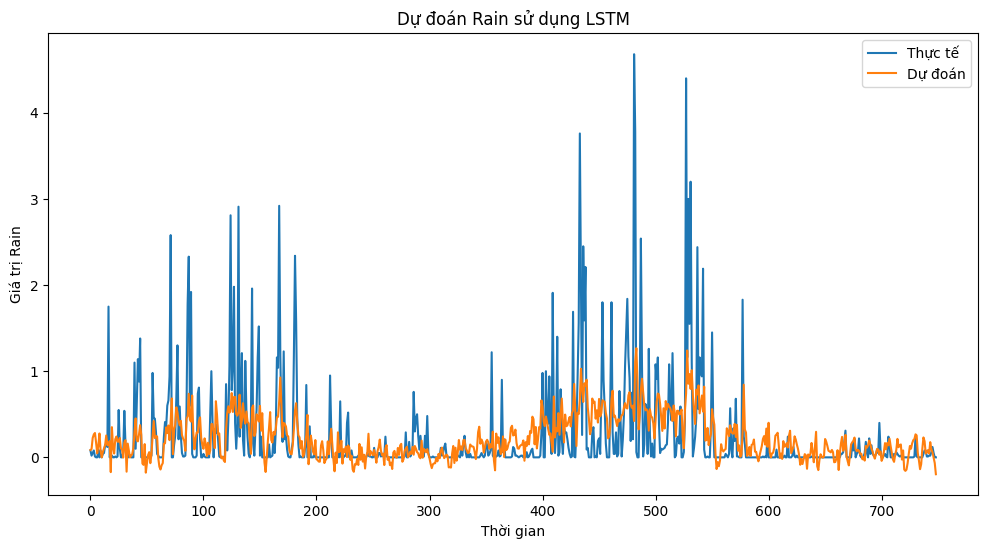

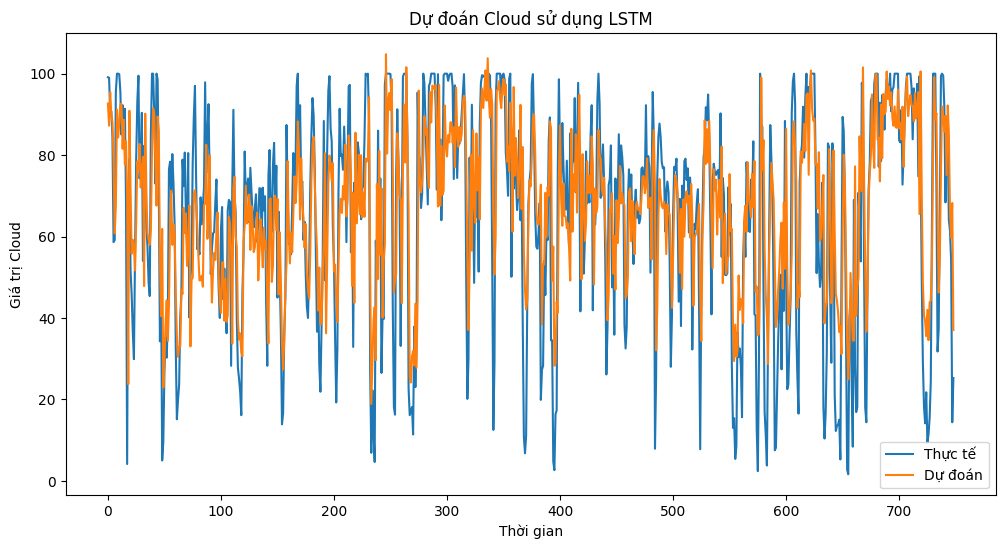

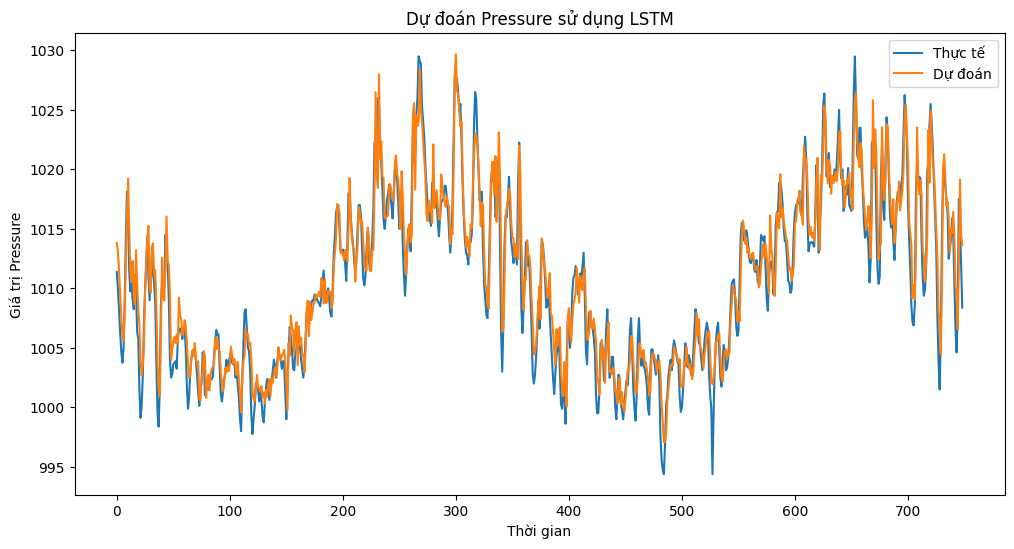

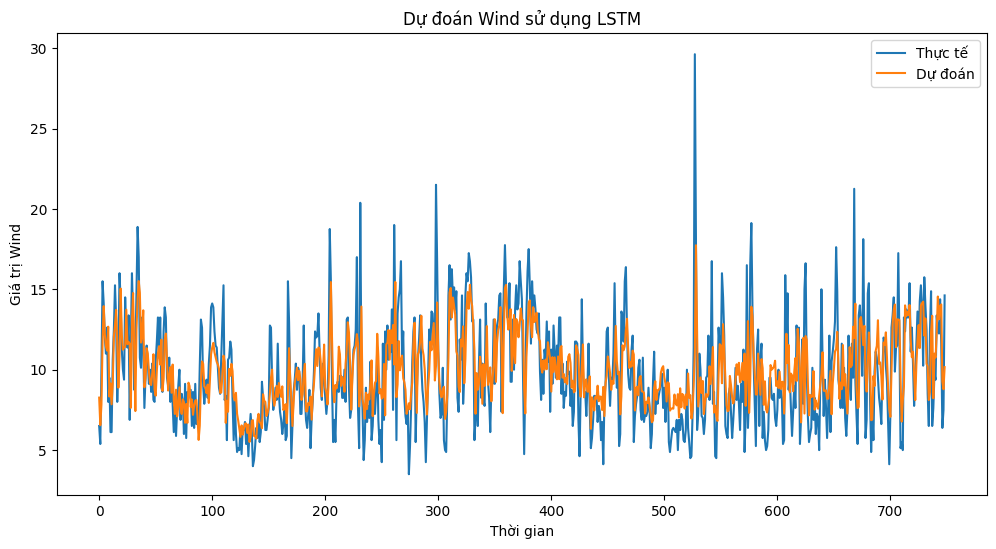

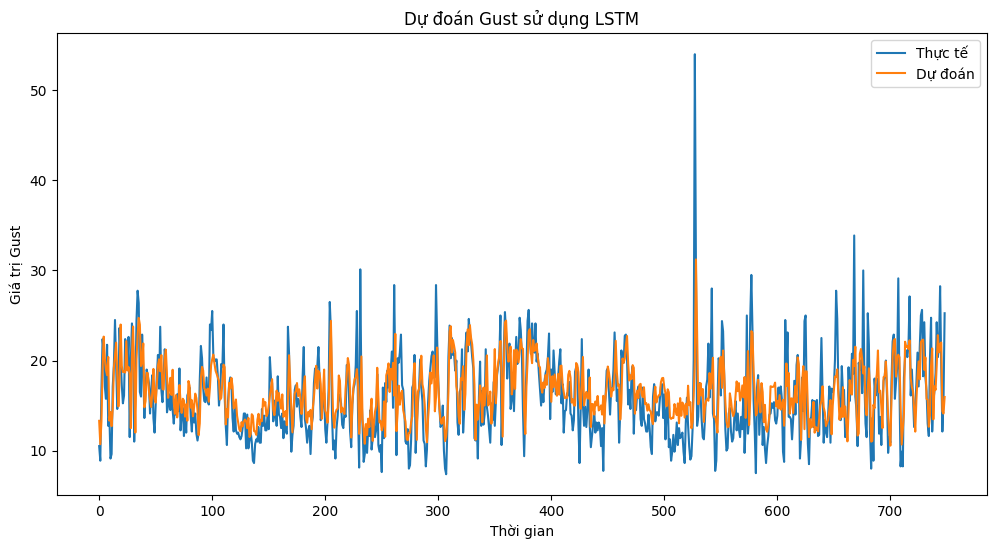

In [15]:
# Vẽ biểu đồ và lưu kết quả dự đoán các yếu tố
for i, feature in enumerate(feature_names):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[:, i], label='Thực tế')
    plt.plot(predictions[:, i], label='Dự đoán')
    plt.title(f'Dự đoán {feature} sử dụng LSTM')
    plt.xlabel('Thời gian')
    plt.ylabel(f'Giá trị {feature}')
    plt.legend()
    plt.savefig(f'../Visualization/Predict_of_model/{feature}_prediction.png')


In [16]:
#Lưu lại mô hình LSTM tốt nhất
torch.save(model.state_dict(), './Built_Model/lstm_model.pth')